# Policy gradients


In this notebook, we'll build a neural network that can learn to play games through reinforcement learning. More specifically, we'll use Q-learning to train an agent to play a game called [Cart-Pole](https://gym.openai.com/envs/CartPole-v0). In this game, a freely swinging pole is attached to a cart. The cart can move to the left and right, and the goal is to keep the pole upright as long as possible.

![Cart-Pole](assets/cart-pole.jpg)

We can simulate this game using [OpenAI Gym](https://gym.openai.com/). First, let's check out how OpenAI Gym works. Then, we'll get into training an agent to play the Cart-Pole game.

In [1]:
# In this one we should define and detect GPUs for tensorflow
# GPUs or CPU
import tensorflow as tf

# Check TensorFlow Version
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.7.1
Default GPU Device: 


>**Note:** Make sure you have OpenAI Gym cloned into the same directory with this notebook. I've included `gym` as a submodule, so you can run `git submodule --init --recursive` to pull the contents into the `gym` repo.

##### >**Note:** Make sure you have OpenAI Gym cloned. Then run this command `pip install -e gym/[all]`.

In [2]:
import gym

## Create the Cart-Pole game environment
env = gym.make('CartPole-v0')
env = gym.make('CartPole-v1')
# env = gym.make('Acrobot-v1')
# env = gym.make('MountainCar-v0')
# env = gym.make('MountainCarContinuous-v0')
# env = gym.make('Pendulum-v0')
# env = gym.make('Blackjack-v0')
# env = gym.make('FrozenLake-v0')
# env = gym.make('AirRaid-ram-v0')
# env = gym.make('AirRaid-v0')
# env = gym.make('BipedalWalker-v2')
# env = gym.make('Copy-v0')
# env = gym.make('CarRacing-v0')
# env = gym.make('Ant-v2') #mujoco
# env = gym.make('FetchPickAndPlace-v1') # mujoco required!

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


/home/arasdar/anaconda3/envs/env/lib/python3.6/site-packages/gym/__init__.py:22: UserWarning: DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.
  warnings.warn('DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.')


We interact with the simulation through `env`. To show the simulation running, you can use `env.render()` to render one frame. Passing in an action as an integer to `env.step` will generate the next step in the simulation.  You can see how many actions are possible from `env.action_space` and to get a random action you can use `env.action_space.sample()`. This is general to all Gym games. In the Cart-Pole game, there are two possible actions, moving the cart left or right. So there are two actions we can take, encoded as 0 and 1.

Run the code below to watch the simulation run.

In [3]:
env.reset()
batch = []
for _ in range(1111):
    #env.render()
    action = env.action_space.sample()
    state, reward, done, info = env.step(action) # take a random action
    batch.append([action, state, reward, done, info])
    #print('state, action, reward, done, info:', state, action, reward, done, info)
    if done:
        env.reset()

To shut the window showing the simulation, use `env.close()`.

In [4]:
# env.close()

If you ran the simulation above, we can look at the rewards:

In [5]:
batch[0], 
batch[0][1].shape, state.shape

((4,), (4,))

In [6]:
import numpy as np
actions = np.array([each[0] for each in batch])
states = np.array([each[1] for each in batch])
rewards = np.array([each[2] for each in batch])
dones = np.array([each[3] for each in batch])
infos = np.array([each[4] for each in batch])

In [7]:
# print(rewards[-20:])
print('shapes:', np.array(rewards).shape, np.array(states).shape, np.array(actions).shape, np.array(dones).shape)
print('dtypes:', np.array(rewards).dtype, np.array(states).dtype, np.array(actions).dtype, np.array(dones).dtype)
print('states:', np.max(np.array(states)), np.min(np.array(states)))
print('actions:', np.max(np.array(actions)), np.min(np.array(actions)))
# print((np.max(np.array(actions)) - np.min(np.array(actions)))+1)
print('rewards:', np.max(np.array(rewards)), np.min(np.array(rewards)))

shapes: (1111,) (1111, 4) (1111,) (1111,)
dtypes: float64 float64 int64 bool
states: 2.329256345617635 -3.0955392005962112
actions: 1 0
rewards: 1.0 1.0


In [8]:
actions[:10]

array([0, 1, 1, 0, 1, 1, 1, 1, 1, 1])

In [9]:
rewards[:10]

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

In [10]:
# import numpy as np
def sigmoid(x, derivative=False):
  return x*(1-x) if derivative else 1/(1+np.exp(-x))

In [11]:
sigmoid(np.max(np.array(rewards))), sigmoid(np.min(np.array(rewards)))

(0.7310585786300049, 0.7310585786300049)

In [12]:
print('rewards:', np.max(np.array(rewards))/100, np.min(np.array(rewards))/100)

rewards: 0.01 0.01


The game resets after the pole has fallen past a certain angle. For each frame while the simulation is running, it returns a reward of 1.0. The longer the game runs, the more reward we get. Then, our network's goal is to maximize the reward by keeping the pole vertical. It will do this by moving the cart to the left and the right.

## Q-Network

We train our Q-learning agent using the Bellman Equation:

$$
Q(s, a) = r + \gamma \max{Q(s', a')}
$$

where $s$ is a state, $a$ is an action, and $s'$ is the next state from state $s$ and action $a$.

Before we used this equation to learn values for a Q-_table_. However, for this game there are a huge number of states available. The state has four values: the position and velocity of the cart, and the position and velocity of the pole. These are all real-valued numbers, so ignoring floating point precisions, you practically have infinite states. Instead of using a table then, we'll replace it with a neural network that will approximate the Q-table lookup function.

<img src="assets/deep-q-learning.png" width=450px>

Now, our Q value, $Q(s, a)$ is calculated by passing in a state to the network. The output will be Q-values for each available action, with fully connected hidden layers.

<img src="assets/q-network.png" width=550px>


As I showed before, we can define our targets for training as $\hat{Q}(s,a) = r + \gamma \max{Q(s', a')}$. Then we update the weights by minimizing $(\hat{Q}(s,a) - Q(s,a))^2$. 

For this Cart-Pole game, we have four inputs, one for each value in the state, and two outputs, one for each action. To get $\hat{Q}$, we'll first choose an action, then simulate the game using that action. This will get us the next state, $s'$, and the reward. With that, we can calculate $\hat{Q}$ then pass it back into the $Q$ network to run the optimizer and update the weights.

Below is my implementation of the Q-network. I used two fully connected layers with ReLU activations. Two seems to be good enough, three might be better. Feel free to try it out.

In [13]:
# Data of the model
def model_input(state_size):
    states = tf.placeholder(tf.float32, [None, state_size], name='states')
    actions = tf.placeholder(tf.int32, [None], name='actions')
    targetQs = tf.placeholder(tf.float32, [None], name='targetQs')
    reward = tf.placeholder(tf.float32, [], name='reward')
    return states, actions, targetQs, reward

In [14]:
# Generator/Controller: Generating/prediting the actions
def generator(states, action_size, hidden_size, reuse=False, alpha=0.1, training=False):
    with tf.variable_scope('generator', reuse=reuse):
        # First fully connected layer
        h1 = tf.layers.dense(inputs=states, units=hidden_size)
        bn1 = tf.layers.batch_normalization(h1, training=training)        
        nl1 = tf.maximum(alpha * bn1, bn1)
        
        # Second fully connected layer
        h2 = tf.layers.dense(inputs=nl1, units=hidden_size)
        bn2 = tf.layers.batch_normalization(h2, training=training)        
        nl2 = tf.maximum(alpha * bn2, bn2)
        
        # Output layer
        logits = tf.layers.dense(inputs=nl2, units=action_size)        
        #predictions = tf.nn.softmax(logits)

        # return actions logits
        return logits

In [15]:
# Discriminator/Dopamine: Reward function/planner/naviator/advisor/supervisor/cortical columns
def discriminator(states, actions, hidden_size, reuse=False, alpha=0.1, training=False):
    with tf.variable_scope('discriminator', reuse=reuse):
        # Fusion/merge states and actions/ SA/ SM
        x_fused = tf.concat(axis=1, values=[states, actions])
        
        # First fully connected layer
        h1 = tf.layers.dense(inputs=x_fused, units=hidden_size)
        bn1 = tf.layers.batch_normalization(h1, training=training)        
        nl1 = tf.maximum(alpha * bn1, bn1)
        
        # Second fully connected layer
        h2 = tf.layers.dense(inputs=nl1, units=hidden_size)
        bn2 = tf.layers.batch_normalization(h2, training=training)        
        nl2 = tf.maximum(alpha * bn2, bn2)
        
        # Output layer
        logits = tf.layers.dense(inputs=nl2, units=1)        
        #predictions = tf.nn.softmax(logits)

        # return rewards logits
        return logits

In [16]:
def model_loss(action_size, hidden_size, states, actions, targetQs, reward): # model input
    actions_logits = generator(states=states, hidden_size=hidden_size, action_size=action_size)
    actions_labels = tf.one_hot(indices=actions, depth=action_size, dtype=actions_logits.dtype)
    neg_log_prob_actions = tf.nn.softmax_cross_entropy_with_logits_v2(logits=actions_logits, 
                                                                      labels=actions_labels)
    #Qs_label = tf.reshape(0.01*targetQs[:-1]) + (0.99*targetQs[1:]), shape=[-1, 1])
    Qs_label = tf.reshape(tf.nn.sigmoid(targetQs[:-1]) + (0.99*targetQs[1:]), shape=[-1, 1])
    Qs_label = tf.concat(axis=0, values=[Qs_label, tf.reshape(tf.nn.sigmoid(targetQs[-1]), shape=[1, 1])])
    g_loss = tf.reduce_mean(neg_log_prob_actions * Qs_label) * reward
    # reward = episode_total_reward/goal_total_reward --> success/fail rate of episode
    #print(Qs_label.shape, neg_log_prob_actions.shape)
    
    Qs_logits = discriminator(actions=actions_logits, hidden_size=hidden_size, states=states) # Q=sum(rewards)
    Qs_logits += discriminator(actions=tf.nn.softmax(actions_logits), hidden_size=hidden_size, states=states, 
                               reuse=True) # Q=sum(rewards)
    Qs_logits += discriminator(actions=actions_labels, hidden_size=hidden_size, states=states, reuse=True)
    Qs_logits /= 3
    d_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=Qs_logits, 
                                                                    labels=reward*tf.ones_like(Qs_logits)))
    g_loss += tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=Qs_logits,
                                                                     labels=tf.nn.sigmoid(Qs_label)))    
    return actions_logits, Qs_logits, g_loss, d_loss

In [17]:
# Optimizating/training/learning G & D
def model_opt(g_loss, d_loss, learning_rate):
    """
    Get optimization operations in order
    :param g_loss: Generator loss Tensor for action prediction
    :param d_loss: Discriminator loss Tensor for reward prediction for generated/prob/logits action
    :param learning_rate: Learning Rate Placeholder
    :return: A tuple of (qfunction training, generator training, discriminator training)
    """
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)): # Required for batchnorm (BN)
        g_opt = tf.train.AdamOptimizer(learning_rate).minimize(g_loss, var_list=g_vars)
        d_opt = tf.train.AdamOptimizer(learning_rate).minimize(d_loss, var_list=d_vars)

    return g_opt, d_opt

In [18]:
class Model:
    def __init__(self, state_size, action_size, hidden_size, learning_rate):

        # Data of the Model: make the data available inside the framework
        self.states, self.actions, self.targetQs, self.reward = model_input(state_size=state_size)

        # Create the Model: calculating the loss and forwad pass
        self.actions_logits, self.Qs_logits, self.g_loss, self.d_loss = model_loss(
            action_size=action_size, hidden_size=hidden_size, # model init parameters
            states=self.states, actions=self.actions, reward=self.reward, targetQs=self.targetQs) # model input
        
        # Update the model: backward pass and backprop
        self.g_opt, self.d_opt = model_opt(g_loss=self.g_loss, d_loss=self.d_loss, learning_rate=learning_rate)

## Hyperparameters

One of the more difficult aspects of reinforcememt learning are the large number of hyperparameters. Not only are we tuning the network, but we're tuning the simulation.

In [19]:
print('state size:{}'.format(states.shape), 
      'actions:{}'.format(actions.shape)) 
print('action size:{}'.format(np.max(actions) - np.min(actions)+1))

state size:(1111, 4) actions:(1111,)
action size:2


In [20]:
# Training parameters
# Network parameters
state_size = 4               # number of units for the input state/observation -- simulation
action_size = 2              # number of units for the output actions -- simulation
hidden_size = 64             # number of units in each Q-network hidden layer -- simulation
learning_rate = 0.001          # learning rate for adam

In [21]:
# Reset/init the graph/session
graph = tf.reset_default_graph()

# Init the model
model = Model(action_size=action_size, hidden_size=hidden_size, state_size=state_size, learning_rate=learning_rate)

## Training the model

Below we'll train our agent. If you want to watch it train, uncomment the `env.render()` line. This is slow because it's rendering the frames slower than the network can train. But, it's cool to watch the agent get better at the game.

In [22]:
# import gym

# ## Create the Cart-Pole game environment
# env = gym.make('CartPole-v0')
# env = gym.make('CartPole-v1')
# env = gym.make('Acrobot-v1')
# # env = gym.make('MountainCar-v0')
# # env = gym.make('Pendulum-v0')
# # env = gym.make('Blackjack-v0')
# # env = gym.make('FrozenLake-v0')
# # env = gym.make('AirRaid-ram-v0')
# # env = gym.make('AirRaid-v0')
# # env = gym.make('BipedalWalker-v2')
# # env = gym.make('Copy-v0')
# # env = gym.make('CarRacing-v0')
# # env = gym.make('Ant-v2') #mujoco
# # env = gym.make('FetchPickAndPlace-v1') # mujoco required!

In [23]:
from collections import deque
episodes_total_reward = deque(maxlen=100) # 100 episodes average/running average/running mean/window

# Now train with experiences
saver = tf.train.Saver()
rewards_list, g_loss_list, d_loss_list = [], [], []

# TF session for training
with tf.Session(graph=graph) as sess:
    sess.run(tf.global_variables_initializer())
    #saver.restore(sess, 'checkpoints/model.ckpt')    
    #saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    
    # Training episodes/epochs
    for ep in range(11111):
        batch = [] # every data batch
        total_reward = 0
        state = env.reset() # env first state

        # Training steps/batches
        #for step in (111111111111):
        while True:
            action_logits = sess.run(model.actions_logits, feed_dict={model.states: np.reshape(state, [1, -1])})
            action = np.argmax(action_logits)
            next_state, reward, done, _ = env.step(action)
            total_reward += reward
            Q_logits = sess.run(model.Qs_logits, feed_dict={model.states: np.reshape(state, [1, -1]), 
                                                            model.actions: np.array([action])})
            targetQ = Q_logits * (1-float(done))
            batch.append([state, action, targetQ])
            state = next_state
            if done is True: # episode ended success/failure
                episodes_total_reward.append(total_reward) # stopping criteria
                resulting_reward = total_reward / 100 # success rate
                break

        # Training using batches
        #batch = memory.buffer
        states = np.array([each[0] for each in batch])
        actions = np.array([each[1] for each in batch])
        targetQs = np.array([each[2] for each in batch])
        #print(targetQs.shape)
        g_loss, d_loss, _, _ = sess.run([model.g_loss, model.d_loss, model.g_opt, model.d_opt], 
                             feed_dict = {model.states: states, 
                                          model.actions: actions,
                                          model.reward: resulting_reward, 
                                          model.targetQs: targetQs.reshape([-1])})
        # Average 100 episode total reward
        # Print out
        print('Episode: {}'.format(ep),
              'mean_episodes_total_reward: {:.4f}'.format(np.mean(episodes_total_reward)),
              'g_loss: {:.4f}'.format(g_loss),
              'd_loss: {:.4f}'.format(d_loss))
        # Ploting out
        rewards_list.append([ep, np.mean(episodes_total_reward)])
        g_loss_list.append([ep, g_loss])
        d_loss_list.append([ep, d_loss])
        # Break episode/epoch loop
        if np.mean(episodes_total_reward) >= 100:
            break
            
    # At the end of all training episodes/epochs
    saver.save(sess, 'checkpoints/model.ckpt')

Episode: 0 mean_episodes_total_reward: 9.0000 g_loss: 0.7236 d_loss: 0.6404
Episode: 1 mean_episodes_total_reward: 9.5000 g_loss: 0.7280 d_loss: 0.6070
Episode: 2 mean_episodes_total_reward: 9.0000 g_loss: 0.7304 d_loss: 0.5867
Episode: 3 mean_episodes_total_reward: 9.2500 g_loss: 0.7309 d_loss: 0.5491
Episode: 4 mean_episodes_total_reward: 9.4000 g_loss: 0.7303 d_loss: 0.5266
Episode: 5 mean_episodes_total_reward: 9.3333 g_loss: 0.7335 d_loss: 0.5098
Episode: 6 mean_episodes_total_reward: 9.2857 g_loss: 0.7319 d_loss: 0.4890
Episode: 7 mean_episodes_total_reward: 9.3750 g_loss: 0.7201 d_loss: 0.4706
Episode: 8 mean_episodes_total_reward: 9.2222 g_loss: 0.7350 d_loss: 0.4545
Episode: 9 mean_episodes_total_reward: 9.3000 g_loss: 0.7078 d_loss: 0.4441
Episode: 10 mean_episodes_total_reward: 11.0909 g_loss: 0.7013 d_loss: 0.6414
Episode: 11 mean_episodes_total_reward: 13.0833 g_loss: 0.6765 d_loss: 0.6776
Episode: 12 mean_episodes_total_reward: 16.4615 g_loss: 0.6658 d_loss: 0.7938
Episod

Episode: 114 mean_episodes_total_reward: 17.4300 g_loss: 0.5203 d_loss: 0.3597
Episode: 115 mean_episodes_total_reward: 17.4300 g_loss: 0.4062 d_loss: 0.5202
Episode: 116 mean_episodes_total_reward: 17.4200 g_loss: 0.4632 d_loss: 0.4264
Episode: 117 mean_episodes_total_reward: 17.4700 g_loss: 0.4440 d_loss: 0.4720
Episode: 118 mean_episodes_total_reward: 17.5100 g_loss: 0.4344 d_loss: 0.4719
Episode: 119 mean_episodes_total_reward: 17.5700 g_loss: 0.4178 d_loss: 0.4872
Episode: 120 mean_episodes_total_reward: 17.6500 g_loss: 0.4223 d_loss: 0.4724
Episode: 121 mean_episodes_total_reward: 17.7400 g_loss: 0.4253 d_loss: 0.4724
Episode: 122 mean_episodes_total_reward: 17.8700 g_loss: 0.4005 d_loss: 0.5337
Episode: 123 mean_episodes_total_reward: 18.0400 g_loss: 0.3563 d_loss: 0.5948
Episode: 124 mean_episodes_total_reward: 18.1400 g_loss: 0.3675 d_loss: 0.5361
Episode: 125 mean_episodes_total_reward: 18.2700 g_loss: 0.3765 d_loss: 0.5510
Episode: 126 mean_episodes_total_reward: 18.2900 g_l

Episode: 222 mean_episodes_total_reward: 23.7800 g_loss: 0.4218 d_loss: 1.0315
Episode: 223 mean_episodes_total_reward: 24.0700 g_loss: 0.4990 d_loss: 0.8261
Episode: 224 mean_episodes_total_reward: 24.4900 g_loss: 0.4528 d_loss: 0.9040
Episode: 225 mean_episodes_total_reward: 24.4700 g_loss: 0.6899 d_loss: 0.5660
Episode: 226 mean_episodes_total_reward: 24.5400 g_loss: 0.6958 d_loss: 0.5561
Episode: 227 mean_episodes_total_reward: 24.5700 g_loss: 0.6891 d_loss: 0.5856
Episode: 228 mean_episodes_total_reward: 24.6000 g_loss: 0.6996 d_loss: 0.5518
Episode: 229 mean_episodes_total_reward: 24.6500 g_loss: 0.6961 d_loss: 0.5632
Episode: 230 mean_episodes_total_reward: 24.6600 g_loss: 0.6896 d_loss: 0.5795
Episode: 231 mean_episodes_total_reward: 24.7600 g_loss: 0.6941 d_loss: 0.5617
Episode: 232 mean_episodes_total_reward: 24.9700 g_loss: 0.6758 d_loss: 0.6188
Episode: 233 mean_episodes_total_reward: 24.9600 g_loss: 0.6976 d_loss: 0.5343
Episode: 234 mean_episodes_total_reward: 24.9500 g_l

Episode: 326 mean_episodes_total_reward: 21.0100 g_loss: 0.2694 d_loss: 0.9778
Episode: 327 mean_episodes_total_reward: 21.3300 g_loss: 0.3285 d_loss: 0.9015
Episode: 328 mean_episodes_total_reward: 21.8800 g_loss: 0.2518 d_loss: 1.0733
Episode: 329 mean_episodes_total_reward: 22.0200 g_loss: 0.4825 d_loss: 0.6567
Episode: 330 mean_episodes_total_reward: 22.1700 g_loss: 0.4636 d_loss: 0.6979
Episode: 331 mean_episodes_total_reward: 22.1600 g_loss: 0.5736 d_loss: 0.4998
Episode: 332 mean_episodes_total_reward: 22.0600 g_loss: 0.5650 d_loss: 0.5094
Episode: 333 mean_episodes_total_reward: 22.0400 g_loss: 0.5895 d_loss: 0.4381
Episode: 334 mean_episodes_total_reward: 22.0500 g_loss: 0.5661 d_loss: 0.4728
Episode: 335 mean_episodes_total_reward: 21.9400 g_loss: 0.5452 d_loss: 0.4689
Episode: 336 mean_episodes_total_reward: 21.8500 g_loss: 0.5759 d_loss: 0.4156
Episode: 337 mean_episodes_total_reward: 21.7700 g_loss: 0.6017 d_loss: 0.3902
Episode: 338 mean_episodes_total_reward: 21.7200 g_l

Episode: 438 mean_episodes_total_reward: 23.8700 g_loss: 0.5844 d_loss: 0.5374
Episode: 439 mean_episodes_total_reward: 24.2500 g_loss: 0.4381 d_loss: 0.7925
Episode: 440 mean_episodes_total_reward: 24.6500 g_loss: 0.5052 d_loss: 0.7718
Episode: 441 mean_episodes_total_reward: 25.2900 g_loss: 0.4519 d_loss: 0.9588
Episode: 442 mean_episodes_total_reward: 25.8600 g_loss: 0.5011 d_loss: 0.8924
Episode: 443 mean_episodes_total_reward: 25.9000 g_loss: 0.6397 d_loss: 0.5001
Episode: 444 mean_episodes_total_reward: 25.9700 g_loss: 0.6448 d_loss: 0.5134
Episode: 445 mean_episodes_total_reward: 25.9800 g_loss: 0.6557 d_loss: 0.4534
Episode: 446 mean_episodes_total_reward: 25.9500 g_loss: 0.6499 d_loss: 0.4577
Episode: 447 mean_episodes_total_reward: 25.9300 g_loss: 0.6391 d_loss: 0.4648
Episode: 448 mean_episodes_total_reward: 25.9600 g_loss: 0.6610 d_loss: 0.4492
Episode: 449 mean_episodes_total_reward: 26.0500 g_loss: 0.6314 d_loss: 0.5070
Episode: 450 mean_episodes_total_reward: 26.5400 g_l

Episode: 544 mean_episodes_total_reward: 31.8700 g_loss: 0.7288 d_loss: 0.7768
Episode: 545 mean_episodes_total_reward: 32.2900 g_loss: 0.7600 d_loss: 0.7197
Episode: 546 mean_episodes_total_reward: 34.8200 g_loss: 0.5812 d_loss: 1.7314
Episode: 547 mean_episodes_total_reward: 35.1600 g_loss: 0.7443 d_loss: 0.7032
Episode: 548 mean_episodes_total_reward: 35.7300 g_loss: 0.7767 d_loss: 0.7655
Episode: 549 mean_episodes_total_reward: 36.2200 g_loss: 0.7828 d_loss: 0.7561
Episode: 550 mean_episodes_total_reward: 35.9000 g_loss: 0.7870 d_loss: 0.6877
Episode: 551 mean_episodes_total_reward: 36.2600 g_loss: 0.7817 d_loss: 0.7084
Episode: 552 mean_episodes_total_reward: 38.2600 g_loss: 1.1031 d_loss: 1.0472
Episode: 553 mean_episodes_total_reward: 39.8600 g_loss: 1.0588 d_loss: 0.9294
Episode: 554 mean_episodes_total_reward: 39.9800 g_loss: 0.7685 d_loss: 0.6619
Episode: 555 mean_episodes_total_reward: 40.2900 g_loss: 0.8109 d_loss: 0.6882
Episode: 556 mean_episodes_total_reward: 41.1800 g_l

Episode: 648 mean_episodes_total_reward: 60.4800 g_loss: 0.7267 d_loss: 0.6609
Episode: 649 mean_episodes_total_reward: 60.2200 g_loss: 0.7255 d_loss: 0.6809
Episode: 650 mean_episodes_total_reward: 60.4200 g_loss: 0.7414 d_loss: 0.7305
Episode: 651 mean_episodes_total_reward: 60.1800 g_loss: 0.7270 d_loss: 0.6341
Episode: 652 mean_episodes_total_reward: 58.3100 g_loss: 0.7258 d_loss: 0.6629
Episode: 653 mean_episodes_total_reward: 56.8100 g_loss: 0.7254 d_loss: 0.6374
Episode: 654 mean_episodes_total_reward: 56.9800 g_loss: 0.7237 d_loss: 0.7043
Episode: 655 mean_episodes_total_reward: 56.8100 g_loss: 0.7243 d_loss: 0.6226
Episode: 656 mean_episodes_total_reward: 56.1300 g_loss: 0.7235 d_loss: 0.6385
Episode: 657 mean_episodes_total_reward: 56.0300 g_loss: 0.7219 d_loss: 0.6638
Episode: 658 mean_episodes_total_reward: 55.6700 g_loss: 0.7231 d_loss: 0.6490
Episode: 659 mean_episodes_total_reward: 55.6000 g_loss: 0.7215 d_loss: 0.6761
Episode: 660 mean_episodes_total_reward: 55.7400 g_l

Episode: 752 mean_episodes_total_reward: 41.5300 g_loss: 0.7314 d_loss: 0.7204
Episode: 753 mean_episodes_total_reward: 41.7500 g_loss: 0.7281 d_loss: 0.7127
Episode: 754 mean_episodes_total_reward: 41.5900 g_loss: 0.7194 d_loss: 0.6411
Episode: 755 mean_episodes_total_reward: 42.0100 g_loss: 0.7316 d_loss: 0.7718
Episode: 756 mean_episodes_total_reward: 42.1700 g_loss: 0.7199 d_loss: 0.7010
Episode: 757 mean_episodes_total_reward: 42.1200 g_loss: 0.7187 d_loss: 0.6403
Episode: 758 mean_episodes_total_reward: 42.3400 g_loss: 0.7229 d_loss: 0.7313
Episode: 759 mean_episodes_total_reward: 42.2400 g_loss: 0.7194 d_loss: 0.6322
Episode: 760 mean_episodes_total_reward: 42.1600 g_loss: 0.7198 d_loss: 0.6579
Episode: 761 mean_episodes_total_reward: 42.2600 g_loss: 0.7199 d_loss: 0.6662
Episode: 762 mean_episodes_total_reward: 42.5200 g_loss: 0.7335 d_loss: 0.7243
Episode: 763 mean_episodes_total_reward: 42.6400 g_loss: 0.7209 d_loss: 0.6894
Episode: 764 mean_episodes_total_reward: 42.8000 g_l

Episode: 859 mean_episodes_total_reward: 41.7000 g_loss: 0.7536 d_loss: 0.7368
Episode: 860 mean_episodes_total_reward: 41.8100 g_loss: 0.7316 d_loss: 0.6967
Episode: 861 mean_episodes_total_reward: 42.1600 g_loss: 0.7667 d_loss: 0.7430
Episode: 862 mean_episodes_total_reward: 42.0500 g_loss: 0.7333 d_loss: 0.6902
Episode: 863 mean_episodes_total_reward: 42.4500 g_loss: 0.7709 d_loss: 0.7489
Episode: 864 mean_episodes_total_reward: 42.5300 g_loss: 0.7441 d_loss: 0.7105
Episode: 865 mean_episodes_total_reward: 42.5800 g_loss: 0.7329 d_loss: 0.6625
Episode: 866 mean_episodes_total_reward: 42.3200 g_loss: 0.7326 d_loss: 0.6574
Episode: 867 mean_episodes_total_reward: 42.4800 g_loss: 0.7475 d_loss: 0.7036
Episode: 868 mean_episodes_total_reward: 42.5900 g_loss: 0.7505 d_loss: 0.7053
Episode: 869 mean_episodes_total_reward: 42.5100 g_loss: 0.7462 d_loss: 0.7003
Episode: 870 mean_episodes_total_reward: 42.3700 g_loss: 0.7423 d_loss: 0.6908
Episode: 871 mean_episodes_total_reward: 42.6300 g_l

Episode: 963 mean_episodes_total_reward: 47.5300 g_loss: 0.7390 d_loss: 0.7398
Episode: 964 mean_episodes_total_reward: 47.2600 g_loss: 0.7224 d_loss: 0.6382
Episode: 965 mean_episodes_total_reward: 47.3700 g_loss: 0.7254 d_loss: 0.6909
Episode: 966 mean_episodes_total_reward: 47.4100 g_loss: 0.7229 d_loss: 0.6664
Episode: 967 mean_episodes_total_reward: 47.4000 g_loss: 0.7251 d_loss: 0.7099
Episode: 968 mean_episodes_total_reward: 47.1800 g_loss: 0.7229 d_loss: 0.6626
Episode: 969 mean_episodes_total_reward: 47.5800 g_loss: 0.7491 d_loss: 0.6959
Episode: 970 mean_episodes_total_reward: 47.8900 g_loss: 0.7396 d_loss: 0.7066
Episode: 971 mean_episodes_total_reward: 47.6600 g_loss: 0.7236 d_loss: 0.6929
Episode: 972 mean_episodes_total_reward: 47.5600 g_loss: 0.7235 d_loss: 0.6760
Episode: 973 mean_episodes_total_reward: 47.8700 g_loss: 0.7289 d_loss: 0.6957
Episode: 974 mean_episodes_total_reward: 47.8500 g_loss: 0.7267 d_loss: 0.6877
Episode: 975 mean_episodes_total_reward: 47.8200 g_l

Episode: 1068 mean_episodes_total_reward: 39.6800 g_loss: 0.6996 d_loss: 0.6720
Episode: 1069 mean_episodes_total_reward: 39.1900 g_loss: 0.7022 d_loss: 0.6913
Episode: 1070 mean_episodes_total_reward: 38.9400 g_loss: 0.7368 d_loss: 0.7124
Episode: 1071 mean_episodes_total_reward: 38.7500 g_loss: 0.6917 d_loss: 0.5997
Episode: 1072 mean_episodes_total_reward: 38.7800 g_loss: 0.6976 d_loss: 0.6773
Episode: 1073 mean_episodes_total_reward: 38.4000 g_loss: 0.6880 d_loss: 0.6377
Episode: 1074 mean_episodes_total_reward: 38.3500 g_loss: 0.7024 d_loss: 0.6615
Episode: 1075 mean_episodes_total_reward: 38.4800 g_loss: 0.7003 d_loss: 0.6918
Episode: 1076 mean_episodes_total_reward: 38.6300 g_loss: 0.7235 d_loss: 0.7113
Episode: 1077 mean_episodes_total_reward: 38.3700 g_loss: 0.7296 d_loss: 0.6908
Episode: 1078 mean_episodes_total_reward: 38.4300 g_loss: 0.7136 d_loss: 0.6804
Episode: 1079 mean_episodes_total_reward: 38.4800 g_loss: 0.7047 d_loss: 0.6519
Episode: 1080 mean_episodes_total_reward

Episode: 1173 mean_episodes_total_reward: 45.9800 g_loss: 0.7223 d_loss: 0.6601
Episode: 1174 mean_episodes_total_reward: 46.0900 g_loss: 0.7223 d_loss: 0.7012
Episode: 1175 mean_episodes_total_reward: 46.2400 g_loss: 0.7418 d_loss: 0.7049
Episode: 1176 mean_episodes_total_reward: 46.0700 g_loss: 0.7209 d_loss: 0.6451
Episode: 1177 mean_episodes_total_reward: 46.4800 g_loss: 0.7699 d_loss: 0.6902
Episode: 1178 mean_episodes_total_reward: 46.6700 g_loss: 0.7232 d_loss: 0.7138
Episode: 1179 mean_episodes_total_reward: 46.7300 g_loss: 0.7190 d_loss: 0.6801
Episode: 1180 mean_episodes_total_reward: 46.7400 g_loss: 0.7225 d_loss: 0.6925
Episode: 1181 mean_episodes_total_reward: 46.9300 g_loss: 0.7411 d_loss: 0.7041
Episode: 1182 mean_episodes_total_reward: 47.1600 g_loss: 0.7217 d_loss: 0.7026
Episode: 1183 mean_episodes_total_reward: 47.5100 g_loss: 0.7607 d_loss: 0.7020
Episode: 1184 mean_episodes_total_reward: 47.5600 g_loss: 0.7225 d_loss: 0.6598
Episode: 1185 mean_episodes_total_reward

Episode: 1278 mean_episodes_total_reward: 42.0600 g_loss: 0.7184 d_loss: 0.6833
Episode: 1279 mean_episodes_total_reward: 41.9300 g_loss: 0.7100 d_loss: 0.6146
Episode: 1280 mean_episodes_total_reward: 42.0800 g_loss: 0.7470 d_loss: 0.7270
Episode: 1281 mean_episodes_total_reward: 41.8000 g_loss: 0.7107 d_loss: 0.6261
Episode: 1282 mean_episodes_total_reward: 41.9600 g_loss: 0.7594 d_loss: 0.7160
Episode: 1283 mean_episodes_total_reward: 41.8300 g_loss: 0.7419 d_loss: 0.7410
Episode: 1284 mean_episodes_total_reward: 41.8700 g_loss: 0.7141 d_loss: 0.6660
Episode: 1285 mean_episodes_total_reward: 41.8300 g_loss: 0.7071 d_loss: 0.6234
Episode: 1286 mean_episodes_total_reward: 42.1600 g_loss: 0.7398 d_loss: 0.7531
Episode: 1287 mean_episodes_total_reward: 42.0300 g_loss: 0.7126 d_loss: 0.6171
Episode: 1288 mean_episodes_total_reward: 42.0800 g_loss: 0.7160 d_loss: 0.6666
Episode: 1289 mean_episodes_total_reward: 42.2700 g_loss: 0.7567 d_loss: 0.7128
Episode: 1290 mean_episodes_total_reward

Episode: 1383 mean_episodes_total_reward: 48.6600 g_loss: 0.7104 d_loss: 0.7225
Episode: 1384 mean_episodes_total_reward: 48.5700 g_loss: 0.7002 d_loss: 0.6086
Episode: 1385 mean_episodes_total_reward: 48.7000 g_loss: 0.7070 d_loss: 0.7005
Episode: 1386 mean_episodes_total_reward: 48.2800 g_loss: 0.6951 d_loss: 0.5594
Episode: 1387 mean_episodes_total_reward: 48.4900 g_loss: 0.7102 d_loss: 0.7306
Episode: 1388 mean_episodes_total_reward: 48.4200 g_loss: 0.6908 d_loss: 0.6213
Episode: 1389 mean_episodes_total_reward: 48.1100 g_loss: 0.6932 d_loss: 0.5931
Episode: 1390 mean_episodes_total_reward: 47.7200 g_loss: 0.7024 d_loss: 0.6704
Episode: 1391 mean_episodes_total_reward: 47.6400 g_loss: 0.7006 d_loss: 0.5743
Episode: 1392 mean_episodes_total_reward: 47.6300 g_loss: 0.6973 d_loss: 0.6436
Episode: 1393 mean_episodes_total_reward: 47.3300 g_loss: 0.6993 d_loss: 0.6456
Episode: 1394 mean_episodes_total_reward: 47.2000 g_loss: 0.6968 d_loss: 0.5784
Episode: 1395 mean_episodes_total_reward

Episode: 1489 mean_episodes_total_reward: 26.7600 g_loss: 0.6506 d_loss: 0.5732
Episode: 1490 mean_episodes_total_reward: 26.5500 g_loss: 0.6664 d_loss: 0.5199
Episode: 1491 mean_episodes_total_reward: 26.4400 g_loss: 0.6670 d_loss: 0.4749
Episode: 1492 mean_episodes_total_reward: 26.2200 g_loss: 0.6566 d_loss: 0.4577
Episode: 1493 mean_episodes_total_reward: 26.0000 g_loss: 0.6583 d_loss: 0.4604
Episode: 1494 mean_episodes_total_reward: 25.9000 g_loss: 0.6240 d_loss: 0.4821
Episode: 1495 mean_episodes_total_reward: 25.7100 g_loss: 0.6316 d_loss: 0.4665
Episode: 1496 mean_episodes_total_reward: 25.5500 g_loss: 0.6183 d_loss: 0.5035
Episode: 1497 mean_episodes_total_reward: 25.4300 g_loss: 0.6211 d_loss: 0.5449
Episode: 1498 mean_episodes_total_reward: 25.3400 g_loss: 0.5960 d_loss: 0.5073
Episode: 1499 mean_episodes_total_reward: 25.2000 g_loss: 0.6087 d_loss: 0.4902
Episode: 1500 mean_episodes_total_reward: 25.0400 g_loss: 0.5178 d_loss: 0.4493
Episode: 1501 mean_episodes_total_reward

Episode: 1595 mean_episodes_total_reward: 50.7200 g_loss: 0.7237 d_loss: 0.6875
Episode: 1596 mean_episodes_total_reward: 51.0800 g_loss: 0.7158 d_loss: 0.7002
Episode: 1597 mean_episodes_total_reward: 51.4000 g_loss: 0.7145 d_loss: 0.6997
Episode: 1598 mean_episodes_total_reward: 51.5800 g_loss: 0.7231 d_loss: 0.6687
Episode: 1599 mean_episodes_total_reward: 52.0200 g_loss: 0.7185 d_loss: 0.7051
Episode: 1600 mean_episodes_total_reward: 52.2000 g_loss: 0.7221 d_loss: 0.6698
Episode: 1601 mean_episodes_total_reward: 52.4700 g_loss: 0.7241 d_loss: 0.6846
Episode: 1602 mean_episodes_total_reward: 52.8300 g_loss: 0.7184 d_loss: 0.6959
Episode: 1603 mean_episodes_total_reward: 53.2700 g_loss: 0.7210 d_loss: 0.7016
Episode: 1604 mean_episodes_total_reward: 53.5100 g_loss: 0.7237 d_loss: 0.6788
Episode: 1605 mean_episodes_total_reward: 53.6900 g_loss: 0.7208 d_loss: 0.6816
Episode: 1606 mean_episodes_total_reward: 53.7200 g_loss: 0.7232 d_loss: 0.6698
Episode: 1607 mean_episodes_total_reward

Episode: 1700 mean_episodes_total_reward: 49.5900 g_loss: 0.7107 d_loss: 0.6986
Episode: 1701 mean_episodes_total_reward: 49.5600 g_loss: 0.7130 d_loss: 0.6867
Episode: 1702 mean_episodes_total_reward: 49.6100 g_loss: 0.7085 d_loss: 0.7008
Episode: 1703 mean_episodes_total_reward: 49.5200 g_loss: 0.7174 d_loss: 0.6908
Episode: 1704 mean_episodes_total_reward: 49.7900 g_loss: 0.6807 d_loss: 0.6755
Episode: 1705 mean_episodes_total_reward: 49.7600 g_loss: 0.7159 d_loss: 0.6799
Episode: 1706 mean_episodes_total_reward: 49.7900 g_loss: 0.7082 d_loss: 0.6916
Episode: 1707 mean_episodes_total_reward: 49.8100 g_loss: 0.7103 d_loss: 0.6951
Episode: 1708 mean_episodes_total_reward: 49.7300 g_loss: 0.7169 d_loss: 0.6631
Episode: 1709 mean_episodes_total_reward: 49.6700 g_loss: 0.7194 d_loss: 0.6703
Episode: 1710 mean_episodes_total_reward: 49.5000 g_loss: 0.7169 d_loss: 0.6986
Episode: 1711 mean_episodes_total_reward: 49.5400 g_loss: 0.7073 d_loss: 0.6990
Episode: 1712 mean_episodes_total_reward

Episode: 1806 mean_episodes_total_reward: 44.1300 g_loss: 0.7225 d_loss: 0.7057
Episode: 1807 mean_episodes_total_reward: 44.0400 g_loss: 0.7229 d_loss: 0.6668
Episode: 1808 mean_episodes_total_reward: 44.2600 g_loss: 0.7211 d_loss: 0.7035
Episode: 1809 mean_episodes_total_reward: 44.4400 g_loss: 0.7232 d_loss: 0.7078
Episode: 1810 mean_episodes_total_reward: 44.4400 g_loss: 0.7246 d_loss: 0.7037
Episode: 1811 mean_episodes_total_reward: 44.4600 g_loss: 0.7229 d_loss: 0.7032
Episode: 1812 mean_episodes_total_reward: 44.5500 g_loss: 0.7244 d_loss: 0.6817
Episode: 1813 mean_episodes_total_reward: 44.5800 g_loss: 0.7243 d_loss: 0.7001
Episode: 1814 mean_episodes_total_reward: 44.7200 g_loss: 0.7184 d_loss: 0.7011
Episode: 1815 mean_episodes_total_reward: 44.9400 g_loss: 0.7149 d_loss: 0.7010
Episode: 1816 mean_episodes_total_reward: 45.0900 g_loss: 0.7211 d_loss: 0.6993
Episode: 1817 mean_episodes_total_reward: 44.9800 g_loss: 0.7210 d_loss: 0.6916
Episode: 1818 mean_episodes_total_reward

Episode: 1910 mean_episodes_total_reward: 47.0000 g_loss: 0.7205 d_loss: 0.6586
Episode: 1911 mean_episodes_total_reward: 47.2500 g_loss: 0.7173 d_loss: 0.7191
Episode: 1912 mean_episodes_total_reward: 47.2400 g_loss: 0.7196 d_loss: 0.6780
Episode: 1913 mean_episodes_total_reward: 47.2700 g_loss: 0.7124 d_loss: 0.7006
Episode: 1914 mean_episodes_total_reward: 47.1500 g_loss: 0.7200 d_loss: 0.6748
Episode: 1915 mean_episodes_total_reward: 47.0600 g_loss: 0.7211 d_loss: 0.6876
Episode: 1916 mean_episodes_total_reward: 47.0300 g_loss: 0.7048 d_loss: 0.6999
Episode: 1917 mean_episodes_total_reward: 46.9100 g_loss: 0.7197 d_loss: 0.6611
Episode: 1918 mean_episodes_total_reward: 46.8400 g_loss: 0.7207 d_loss: 0.6623
Episode: 1919 mean_episodes_total_reward: 46.8200 g_loss: 0.7181 d_loss: 0.6772
Episode: 1920 mean_episodes_total_reward: 46.9600 g_loss: 0.6985 d_loss: 0.6952
Episode: 1921 mean_episodes_total_reward: 47.1900 g_loss: 0.7187 d_loss: 0.6807
Episode: 1922 mean_episodes_total_reward

Episode: 2013 mean_episodes_total_reward: 45.1900 g_loss: 0.7203 d_loss: 0.6807
Episode: 2014 mean_episodes_total_reward: 45.4100 g_loss: 0.7182 d_loss: 0.7251
Episode: 2015 mean_episodes_total_reward: 45.3100 g_loss: 0.7194 d_loss: 0.6525
Episode: 2016 mean_episodes_total_reward: 45.1800 g_loss: 0.7203 d_loss: 0.6553
Episode: 2017 mean_episodes_total_reward: 45.4000 g_loss: 0.7158 d_loss: 0.7085
Episode: 2018 mean_episodes_total_reward: 45.3600 g_loss: 0.7208 d_loss: 0.6451
Episode: 2019 mean_episodes_total_reward: 45.3500 g_loss: 0.7175 d_loss: 0.6757
Episode: 2020 mean_episodes_total_reward: 45.2500 g_loss: 0.7193 d_loss: 0.6960
Episode: 2021 mean_episodes_total_reward: 45.0800 g_loss: 0.7200 d_loss: 0.6993
Episode: 2022 mean_episodes_total_reward: 45.0300 g_loss: 0.7197 d_loss: 0.6615
Episode: 2023 mean_episodes_total_reward: 44.9900 g_loss: 0.7198 d_loss: 0.6627
Episode: 2024 mean_episodes_total_reward: 45.0600 g_loss: 0.7179 d_loss: 0.6906
Episode: 2025 mean_episodes_total_reward

Episode: 2117 mean_episodes_total_reward: 44.2200 g_loss: 0.7197 d_loss: 0.6527
Episode: 2118 mean_episodes_total_reward: 44.4300 g_loss: 0.7210 d_loss: 0.7112
Episode: 2119 mean_episodes_total_reward: 44.5300 g_loss: 0.7197 d_loss: 0.6994
Episode: 2120 mean_episodes_total_reward: 44.5200 g_loss: 0.7178 d_loss: 0.6932
Episode: 2121 mean_episodes_total_reward: 44.3900 g_loss: 0.7207 d_loss: 0.6599
Episode: 2122 mean_episodes_total_reward: 44.4200 g_loss: 0.7186 d_loss: 0.6714
Episode: 2123 mean_episodes_total_reward: 44.8300 g_loss: 0.7277 d_loss: 0.7625
Episode: 2124 mean_episodes_total_reward: 44.6700 g_loss: 0.7212 d_loss: 0.6303
Episode: 2125 mean_episodes_total_reward: 44.7200 g_loss: 0.7185 d_loss: 0.7044
Episode: 2126 mean_episodes_total_reward: 44.4600 g_loss: 0.7300 d_loss: 0.7117
Episode: 2127 mean_episodes_total_reward: 44.6200 g_loss: 0.7213 d_loss: 0.7168
Episode: 2128 mean_episodes_total_reward: 44.3100 g_loss: 0.7200 d_loss: 0.6722
Episode: 2129 mean_episodes_total_reward

Episode: 2222 mean_episodes_total_reward: 52.8100 g_loss: 0.6815 d_loss: 0.6990
Episode: 2223 mean_episodes_total_reward: 52.8900 g_loss: 0.5478 d_loss: 0.4815
Episode: 2224 mean_episodes_total_reward: 53.0200 g_loss: 0.7160 d_loss: 0.6860
Episode: 2225 mean_episodes_total_reward: 52.8800 g_loss: 0.7062 d_loss: 0.6863
Episode: 2226 mean_episodes_total_reward: 53.0700 g_loss: 0.5496 d_loss: 0.5644
Episode: 2227 mean_episodes_total_reward: 52.9200 g_loss: 0.7135 d_loss: 0.6846
Episode: 2228 mean_episodes_total_reward: 52.9000 g_loss: 0.7197 d_loss: 0.6693
Episode: 2229 mean_episodes_total_reward: 52.9000 g_loss: 0.6914 d_loss: 0.7024
Episode: 2230 mean_episodes_total_reward: 52.7900 g_loss: 0.7048 d_loss: 0.7029
Episode: 2231 mean_episodes_total_reward: 52.8700 g_loss: 0.6575 d_loss: 0.6968
Episode: 2232 mean_episodes_total_reward: 52.9200 g_loss: 0.7106 d_loss: 0.6752
Episode: 2233 mean_episodes_total_reward: 52.9400 g_loss: 0.7180 d_loss: 0.6739
Episode: 2234 mean_episodes_total_reward

Episode: 2325 mean_episodes_total_reward: 49.6900 g_loss: 0.6807 d_loss: 0.5543
Episode: 2326 mean_episodes_total_reward: 49.3700 g_loss: 0.6812 d_loss: 0.7070
Episode: 2327 mean_episodes_total_reward: 49.7200 g_loss: 0.6300 d_loss: 0.6089
Episode: 2328 mean_episodes_total_reward: 49.6800 g_loss: 0.7173 d_loss: 0.6568
Episode: 2329 mean_episodes_total_reward: 49.5700 g_loss: 0.7158 d_loss: 0.6611
Episode: 2330 mean_episodes_total_reward: 49.4500 g_loss: 0.7126 d_loss: 0.6832
Episode: 2331 mean_episodes_total_reward: 50.0800 g_loss: 0.6130 d_loss: 0.3408
Episode: 2332 mean_episodes_total_reward: 50.2800 g_loss: 0.6527 d_loss: 0.7057
Episode: 2333 mean_episodes_total_reward: 50.3200 g_loss: 0.6925 d_loss: 0.7018
Episode: 2334 mean_episodes_total_reward: 50.6000 g_loss: 0.6093 d_loss: 0.6459
Episode: 2335 mean_episodes_total_reward: 50.5400 g_loss: 0.7153 d_loss: 0.6972
Episode: 2336 mean_episodes_total_reward: 50.3400 g_loss: 0.7093 d_loss: 0.6824
Episode: 2337 mean_episodes_total_reward

Episode: 2428 mean_episodes_total_reward: 61.9900 g_loss: 0.6503 d_loss: 0.6661
Episode: 2429 mean_episodes_total_reward: 62.0900 g_loss: 0.5801 d_loss: 0.8191
Episode: 2430 mean_episodes_total_reward: 62.1800 g_loss: 0.6120 d_loss: 0.7472
Episode: 2431 mean_episodes_total_reward: 61.4100 g_loss: 0.6066 d_loss: 0.7967
Episode: 2432 mean_episodes_total_reward: 61.2800 g_loss: 0.5870 d_loss: 0.8362
Episode: 2433 mean_episodes_total_reward: 61.2500 g_loss: 0.5979 d_loss: 0.8249
Episode: 2434 mean_episodes_total_reward: 60.9900 g_loss: 0.6439 d_loss: 0.7481
Episode: 2435 mean_episodes_total_reward: 61.1600 g_loss: 0.6512 d_loss: 0.6683
Episode: 2436 mean_episodes_total_reward: 61.4500 g_loss: 0.7065 d_loss: 0.6915
Episode: 2437 mean_episodes_total_reward: 61.9000 g_loss: 0.7093 d_loss: 0.6851
Episode: 2438 mean_episodes_total_reward: 61.8600 g_loss: 0.6623 d_loss: 0.7255
Episode: 2439 mean_episodes_total_reward: 61.9800 g_loss: 0.6593 d_loss: 0.7104
Episode: 2440 mean_episodes_total_reward

Episode: 2534 mean_episodes_total_reward: 54.8900 g_loss: 0.7136 d_loss: 0.6972
Episode: 2535 mean_episodes_total_reward: 54.5300 g_loss: 0.7142 d_loss: 0.6203
Episode: 2536 mean_episodes_total_reward: 54.4300 g_loss: 0.7115 d_loss: 0.7464
Episode: 2537 mean_episodes_total_reward: 53.9500 g_loss: 0.7141 d_loss: 0.6245
Episode: 2538 mean_episodes_total_reward: 53.9800 g_loss: 0.7105 d_loss: 0.7207
Episode: 2539 mean_episodes_total_reward: 53.8400 g_loss: 0.7134 d_loss: 0.6594
Episode: 2540 mean_episodes_total_reward: 53.6200 g_loss: 0.7145 d_loss: 0.6452
Episode: 2541 mean_episodes_total_reward: 53.4400 g_loss: 0.7148 d_loss: 0.6057
Episode: 2542 mean_episodes_total_reward: 53.2100 g_loss: 0.7150 d_loss: 0.6062
Episode: 2543 mean_episodes_total_reward: 52.6000 g_loss: 0.7098 d_loss: 0.7546
Episode: 2544 mean_episodes_total_reward: 52.2400 g_loss: 0.7129 d_loss: 0.6444
Episode: 2545 mean_episodes_total_reward: 51.9300 g_loss: 0.7142 d_loss: 0.6148
Episode: 2546 mean_episodes_total_reward

Episode: 2641 mean_episodes_total_reward: 33.8500 g_loss: 0.6767 d_loss: 0.5610
Episode: 2642 mean_episodes_total_reward: 33.8500 g_loss: 0.6700 d_loss: 0.5769
Episode: 2643 mean_episodes_total_reward: 33.5000 g_loss: 0.6783 d_loss: 0.5332
Episode: 2644 mean_episodes_total_reward: 33.4500 g_loss: 0.6607 d_loss: 0.6027
Episode: 2645 mean_episodes_total_reward: 33.3800 g_loss: 0.6728 d_loss: 0.5314
Episode: 2646 mean_episodes_total_reward: 33.1400 g_loss: 0.6544 d_loss: 0.5844
Episode: 2647 mean_episodes_total_reward: 32.9000 g_loss: 0.6670 d_loss: 0.5189
Episode: 2648 mean_episodes_total_reward: 32.5600 g_loss: 0.6577 d_loss: 0.5549
Episode: 2649 mean_episodes_total_reward: 32.5000 g_loss: 0.6521 d_loss: 0.5543
Episode: 2650 mean_episodes_total_reward: 32.2200 g_loss: 0.6584 d_loss: 0.5035
Episode: 2651 mean_episodes_total_reward: 32.0800 g_loss: 0.6549 d_loss: 0.5120
Episode: 2652 mean_episodes_total_reward: 31.9000 g_loss: 0.6267 d_loss: 0.6062
Episode: 2653 mean_episodes_total_reward

Episode: 2748 mean_episodes_total_reward: 29.2300 g_loss: 0.6727 d_loss: 0.6077
Episode: 2749 mean_episodes_total_reward: 29.2500 g_loss: 0.6721 d_loss: 0.5854
Episode: 2750 mean_episodes_total_reward: 29.3600 g_loss: 0.6642 d_loss: 0.6142
Episode: 2751 mean_episodes_total_reward: 29.4300 g_loss: 0.6722 d_loss: 0.5925
Episode: 2752 mean_episodes_total_reward: 29.4400 g_loss: 0.6548 d_loss: 0.6134
Episode: 2753 mean_episodes_total_reward: 29.5200 g_loss: 0.6534 d_loss: 0.6209
Episode: 2754 mean_episodes_total_reward: 29.5200 g_loss: 0.6555 d_loss: 0.6054
Episode: 2755 mean_episodes_total_reward: 29.4600 g_loss: 0.6566 d_loss: 0.5727
Episode: 2756 mean_episodes_total_reward: 29.4900 g_loss: 0.6419 d_loss: 0.5878
Episode: 2757 mean_episodes_total_reward: 29.5200 g_loss: 0.6512 d_loss: 0.5626
Episode: 2758 mean_episodes_total_reward: 29.5600 g_loss: 0.6355 d_loss: 0.6041
Episode: 2759 mean_episodes_total_reward: 29.6000 g_loss: 0.6174 d_loss: 0.6385
Episode: 2760 mean_episodes_total_reward

Episode: 2852 mean_episodes_total_reward: 87.4100 g_loss: 1.0683 d_loss: -5.8098
Episode: 2853 mean_episodes_total_reward: 89.0600 g_loss: 0.8702 d_loss: -3.4252
Episode: 2854 mean_episodes_total_reward: 89.8900 g_loss: 0.3922 d_loss: -0.5596
Episode: 2855 mean_episodes_total_reward: 90.3000 g_loss: 0.2992 d_loss: 1.4419
Episode: 2856 mean_episodes_total_reward: 91.0000 g_loss: 0.3204 d_loss: 0.1503
Episode: 2857 mean_episodes_total_reward: 91.9500 g_loss: 0.4635 d_loss: -1.1507
Episode: 2858 mean_episodes_total_reward: 92.2300 g_loss: 0.2838 d_loss: 2.2253
Episode: 2859 mean_episodes_total_reward: 92.6500 g_loss: 0.3552 d_loss: 1.3565
Episode: 2860 mean_episodes_total_reward: 92.8500 g_loss: 0.2390 d_loss: 2.8001
Episode: 2861 mean_episodes_total_reward: 93.4200 g_loss: 0.2300 d_loss: 0.9407
Episode: 2862 mean_episodes_total_reward: 93.7400 g_loss: 0.2224 d_loss: 2.0681
Episode: 2863 mean_episodes_total_reward: 94.9100 g_loss: 0.3964 d_loss: -2.4095
Episode: 2864 mean_episodes_total_r

# Visualizing training

Below I'll plot the total rewards for each episode. I'm plotting the rolling average too, in blue.

In [24]:
import matplotlib.pyplot as plt
%matplotlib inline

def running_mean(x, N):
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return (cumsum[N:] - cumsum[:-N]) / N 

Text(0,0.5,'Total rewards')

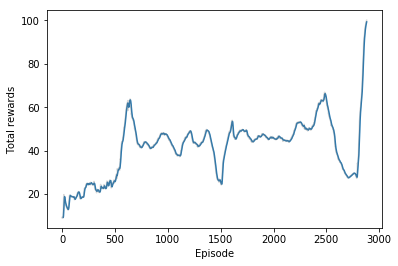

In [25]:
eps, arr = np.array(rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0,0.5,'G losses')

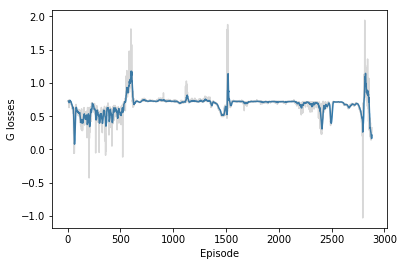

In [26]:
eps, arr = np.array(g_loss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('G losses')

Text(0,0.5,'D losses')

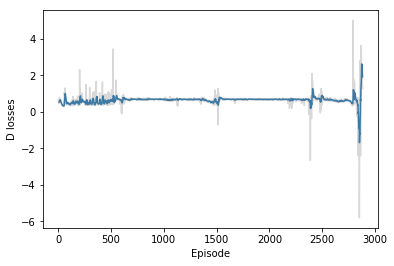

In [27]:
eps, arr = np.array(d_loss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('D losses')

## Testing

Let's checkout how our trained agent plays the game.

In [28]:
import gym
env = gym.make('CartPole-v0')
env = gym.make('CartPole-v1')
# env = gym.make('Acrobot-v1')
# env = gym.make('MountainCar-v0')
# env = gym.make('Pendulum-v0')
# env = gym.make('Blackjack-v0')
# env = gym.make('FrozenLake-v0')
# env = gym.make('AirRaid-ram-v0')
# env = gym.make('AirRaid-v0')
# env = gym.make('BipedalWalker-v2')
# env = gym.make('Copy-v0')
# env = gym.make('CarRacing-v0')
# env = gym.make('Ant-v2') #mujoco
# env = gym.make('FetchPickAndPlace-v1') # mujoco required!

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    #saver.restore(sess, 'checkpoints/model.ckpt')    
    saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    
    # Episodes/epochs
    for _ in range(1):
    #while True:
        state = env.reset()
        total_reward = 0

        # Steps/batches
        #for _ in range(111111111111111111):
        while True:
            env.render()
            action_logits = sess.run(model.actions_logits, feed_dict={model.states: np.reshape(state, [1, -1])})
            action = np.argmax(action_logits)
            state, reward, done, _ = env.step(action)
            total_reward += reward
            if done:
                break
        # Print and break condition
        print('total_reward: {}'.format(total_reward))
        if total_reward == 500:
            break
                
# Closing the env
env.close()

/home/arasdar/anaconda3/envs/env/lib/python3.6/site-packages/gym/__init__.py:22: UserWarning: DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.
  warnings.warn('DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.')


WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
INFO:tensorflow:Restoring parameters from checkpoints/model2.ckpt
total_reward: 500.0


## Extending this

So, Cart-Pole is a pretty simple game. However, the same model can be used to train an agent to play something much more complicated like Pong or Space Invaders. Instead of a state like we're using here though, you'd want to use convolutional layers to get the state from the screen images.

![Deep Q-Learning Atari](assets/atari-network.png)

I'll leave it as a challenge for you to use deep Q-learning to train an agent to play Atari games. Here's the original paper which will get you started: http://www.davidqiu.com:8888/research/nature14236.pdf.